# Titanic ML

## Loading libraries

In [152]:
import numpy as np
import random
import pandas as pd
import tensorflow as tf
import shutil
from google.datalab.ml import TensorBoard
print(tf.__version__)

1.8.0


## Loadind the data

In [153]:
df_input = pd.read_csv('titanic_data.csv')
df_input.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


* survival: Survival (0 = No; 1 = Yes)
* class: Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
* name: Name
* sex: Sex
* age: Age
* sibsp: Number of Siblings/Spouses Aboard
* parch: Number of Parents/Children Aboard
* ticket: Ticket Number
* fare: Passenger Fare
* cabin: Cabin
* embarked: Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

## Exploratory Data Analysis (EDA)

In [155]:
# Total of rows
print(len(df_input))

# How many of them survived?
print(df_input.Survived.sum())

# How many of them did not survive?
print(df_input.Survived.mean())

891
342
0.3838383838383838


In [156]:
# % of survivors by gender
df_input.groupby(['Sex'])['Survived'].mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

In [157]:
# % of survivors by gender
df_input.groupby(['Sex']).agg({'PassengerId': 'count', 'Survived':['sum', 'mean']})

PassengerId Survived          
             count      sum      mean
Sex                                  
female         314      233  0.742038
male           577      109  0.188908

In [158]:
# % of survivors by gender and class
df_input.groupby(['Sex', 'Pclass']).agg({'PassengerId': 'count', 'Survived':['sum', 'mean']})

PassengerId Survived          
                    count      sum      mean
Sex    Pclass                               
female 1               94       91  0.968085
       2               76       70  0.921053
       3              144       72  0.500000
male   1              122       45  0.368852
       2              108       17  0.157407
       3              347       47  0.135447

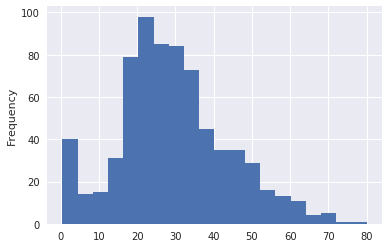

In [159]:
# Histogram for age distribution
df_input.Age.plot.hist(bins = 20)

## Tensorflow

**How is a model trained?**

    - Weights
    - Loss function

### Spliting dataset

In [160]:
np.random.seed(1) 

# Spliting into train and test
msk = np.random.rand(len(df_input)) < 0.8
print(msk[1:10])
print("Total True values: " + str(sum(msk)))
print("Total number of rows: " + str(len(msk)))
print("Rate of True values: " + str(1.0*sum(msk)/len(msk)))

[ True  True  True  True  True  True  True  True  True]
Total True values: 715
Total number of rows: 891
Rate of True values: 0.802469135802


In [161]:
# Train
df_train = df_input[msk]

# Evaluation
df_evaluation = df_input[~msk]

print("Train sample size is " + str(len(df_train)) + " and Evaluation sample size is: " + str(len(df_evaluation)))
print("Together: " + str(len(df_train) + len(df_evaluation))) 

Train sample size is 715 and Evaluation sample size is: 176
Together: 891


### Sanity check

In [162]:
print(df_train.Survived.mean())
print(df_evaluation.Survived.mean())

0.38461538461538464
0.3806818181818182


### Train and eval input functions to read from Pandas Dataframe

In [163]:
def make_train_input_fn(df, num_epochs, columns):
    return tf.estimator.inputs.pandas_input_fn(
        x = df[columns],
        y = df[columns[0]],
        batch_size = 40,
        num_epochs = num_epochs,
        shuffle = True,
        queue_capacity = 100
  )

In [164]:
def make_eval_input_fn(df, columns):
  # When we evaluate the model, we do it just in one epoch. This is important
  return tf.estimator.inputs.pandas_input_fn(
    x = df[columns],
    y = df[columns[0]],
    batch_size = 40,
    shuffle = False,
    queue_capacity = 100
  )

In [165]:
def make_prediction_input_fn(df):
    return tf.estimator.inputs.pandas_input_fn(
        x = df,
        y = None,
        batch_size = 128,
        shuffle = False,
        queue_capacity = 100
    )

### Linear Classifier with tf.Estimator framework 

In [166]:
# Setting the output directory
OUTDIR = './titanic_trained'

# Target column name
target = 'Survived'

In [167]:
# Features in a "tensorflow way"
features = ['Sex']
cols =  [target] + features

# This is for Sex
features_tensorflow = [
    tf.feature_column.categorical_column_with_vocabulary_list(
        key = features[0],
        vocabulary_list = ['female', 'male']
    )
]

### Training process

In [168]:
tf.logging.set_verbosity(tf.logging.INFO)

# start fresh each time
shutil.rmtree(
  OUTDIR, 
  ignore_errors = True
) 

model = tf.estimator.LinearClassifier(
  feature_columns = features_tensorflow, 
  model_dir = OUTDIR
)

model.train(
  input_fn = make_train_input_fn(
    df = df_train, 
    num_epochs = 10,
    columns = cols
  )
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4ee1d313d0>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': './titanic_trained', '_global_id_in_cluster': 0, '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ./titanic_trained/model.ckpt.
INFO:tensorflow:loss = 27.

### Reporting loss

**Why do we need an evaluation dataset?**
    
    - Model can memorise trainig data. It is not escalable?

In [77]:
def print_crossentropy(model, df, columns):
    metrics = model.evaluate(
        input_fn = make_eval_input_fn(
            df = df,
            columns = columns
        )
    )
    print('Cross entropy on dataset = {}'.format(metrics['average_loss']))

In [92]:
print_crossentropy(model, df_evaluation, cols)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-05-23-09:16:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from titanic_trained/model.ckpt-179
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-05-23-09:16:48
INFO:tensorflow:Saving dict for global step 179: accuracy = 0.77840906, accuracy_baseline = 0.6193182, auc = 0.75783926, auc_precision_recall = 0.7612241, average_loss = 0.5253899, global_step = 179, label/mean = 0.3806818, loss = 18.493725, precision = 0.7258065, prediction/mean = 0.39129332, recall = 0.67164177
Cross entropy on dataset = 0.525389909744


### Improving loss function: Adding more features

In [110]:
df_train.loc[:,'Pclass_mod'] = df_train['Pclass'] - 1
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_mod
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,2


In [108]:
df_evaluation.loc[:, 'Pclass_mod'] = df_evaluation['Pclass'] - 1
df_evaluation.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_mod
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S,2
20,21,0,2,"Fynney, Mr. Joseph J",male,35.0,0,0,239865,26.0000,NaN,S,1
21,22,1,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S,1
24,25,0,3,"Palsson, Miss. Torborg Danira",female,8.0,3,1,349909,21.0750,NaN,S,2
25,26,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,NaN,S,2


In [111]:
print("Missing values for Age: " + str(sum(df_train.Age.isnull())))
df_train.Age.fillna(df_train.Age.mean(), inplace=True)
print("Missing values for Age after replacing: " + str(sum(df_train.Age.isnull())))

Missing values for Age: 142
Missing values for Age after replacing: 0


In [112]:
df_evaluation.Age.fillna(df_train.Age.mean(), inplace=True)

In [113]:
# Features in a "tensorflow way"
features = ['Sex', 'Pclass_mod', 'Age']
cols =  [target] + features

features_tensorflow = [
    # This is for Sex
    tf.feature_column.categorical_column_with_vocabulary_list(
        key = features[0],
        vocabulary_list = ['female', 'male']
    ),
    
    # This is for Pclass_mod
    tf.feature_column.categorical_column_with_identity(
        key = features[1],
        num_buckets = 3
    ),
    
    # This is for age
    tf.feature_column.numeric_column(
        key = features[2]
    )
]

In [114]:
tf.logging.set_verbosity(tf.logging.INFO)

# start fresh each time
shutil.rmtree(
  OUTDIR, 
  ignore_errors = True
) 

model = tf.estimator.LinearClassifier(
  feature_columns = features_tensorflow, 
  model_dir = OUTDIR
)

model.train(
  input_fn = make_train_input_fn(
    df = df_train, 
    num_epochs = 10,
    columns = cols
  )
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4ee005b0d0>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'titanic_trained', '_global_id_in_cluster': 0, '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into titanic_trained/model.ckpt.
INFO:tensorflow:loss = 27.7258

In [115]:
print_crossentropy(model, df_evaluation, cols)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-05-23-09:29:02
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from titanic_trained/model.ckpt-179
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-05-23-09:29:03
INFO:tensorflow:Saving dict for global step 179: accuracy = 0.77840906, accuracy_baseline = 0.6193182, auc = 0.8389019, auc_precision_recall = 0.8032205, average_loss = 0.4530419, global_step = 179, label/mean = 0.3806818, loss = 15.947075, precision = 0.71875, prediction/mean = 0.39002886, recall = 0.6865672
Cross entropy on dataset = 0.453041911125


### Improving loss function: Feature engineering

In [121]:
df_train.loc[:, 'classSex'] = df_train['Pclass'].astype(str) + df_train['Sex']
df_evaluation.loc[:, 'classSex'] = df_evaluation['Pclass'].astype(str) + df_evaluation['Sex']
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_mod,classSex
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,3male
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1female
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2,3female
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,1female
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,2,3male


In [122]:
# Features in a "tensorflow way"
features = ['classSex', 'Age']
cols =  [target] + features

features_tensorflow = [
    # This is for classSex
    tf.feature_column.categorical_column_with_vocabulary_list(
        key = features[0],
        vocabulary_list = ['1female', '2female', '3female', '1male', '2male', '3male']
    ),
    
    
    # This is for age
    tf.feature_column.numeric_column(
        key = features[1]
    )
]

In [123]:
tf.logging.set_verbosity(tf.logging.INFO)

# start fresh each time
shutil.rmtree(
  OUTDIR, 
  ignore_errors = True
) 

model = tf.estimator.LinearClassifier(
  feature_columns = features_tensorflow, 
  model_dir = OUTDIR
)

model.train(
  input_fn = make_train_input_fn(
    df = df_train, 
    num_epochs = 10,
    columns = cols
  )
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4ee1b3f790>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'titanic_trained', '_global_id_in_cluster': 0, '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into titanic_trained/model.ckpt.
INFO:tensorflow:loss = 27.7258

In [124]:
print_crossentropy(model, df_evaluation, cols)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-05-23-09:36:24
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from titanic_trained/model.ckpt-179
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-05-23-09:36:25
INFO:tensorflow:Saving dict for global step 179: accuracy = 0.78409094, accuracy_baseline = 0.6193182, auc = 0.839655, auc_precision_recall = 0.79476655, average_loss = 0.44949684, global_step = 179, label/mean = 0.3806818, loss = 15.8222885, precision = 0.73015875, prediction/mean = 0.40948045, recall = 0.6865672
Cross entropy on dataset = 0.44949683547


## More metrics
    - Why is reporting loss function a bad idea?? Business does not care about it since loss does not contain any business meaning.

### Accuracy

**How is it calculated?**

$\frac{TP+TN}{Total}$

In [127]:
# Computing accuracy
def print_accuracy(model, df, columns):
    metrics = model.evaluate(
        input_fn = make_eval_input_fn(
            df = df,
            columns = columns
        )
    )
    print('Accuracy on dataset = {}'.format(metrics['accuracy']))


In [128]:
print_accuracy(model, df_evaluation, cols)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-05-23-09:42:35
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from titanic_trained/model.ckpt-179
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-05-23-09:42:36
INFO:tensorflow:Saving dict for global step 179: accuracy = 0.78409094, accuracy_baseline = 0.6193182, auc = 0.839655, auc_precision_recall = 0.79476655, average_loss = 0.44949684, global_step = 179, label/mean = 0.3806818, loss = 15.8222885, precision = 0.73015875, prediction/mean = 0.40948045, recall = 0.6865672
Accuracy on dataset = 0.784090936184


**What's wrong with this metric?**
    - It is threshold dependant.
    - It does not work with unbalanced datasets


### Precission

**How is it calculated?**

$\frac{TP}{\mbox{Predicted positive}}$

In [129]:
# Computing accuracy
def print_precision(model, df, columns):
    metrics = model.evaluate(
        input_fn = make_eval_input_fn(
            df = df,
            columns = columns
        )
    )
    print('Precision on dataset = {}'.format(metrics['precision']))

In [130]:
print_precision(model, df_evaluation, cols)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-05-23-09:43:23
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from titanic_trained/model.ckpt-179
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-05-23-09:43:24
INFO:tensorflow:Saving dict for global step 179: accuracy = 0.78409094, accuracy_baseline = 0.6193182, auc = 0.839655, auc_precision_recall = 0.79476655, average_loss = 0.44949684, global_step = 179, label/mean = 0.3806818, loss = 15.8222885, precision = 0.73015875, prediction/mean = 0.40948045, recall = 0.6865672
Precision on dataset = 0.730158746243


**What's wrong with this metric?**
- It is threshold dependant.
- Model can underpredict positive class

### Recall

**How is it calculated?**

$\frac{TP}{P}$

In [132]:
# Computing recall
def print_recall(model, df, columns):
    metrics = model.evaluate(
        input_fn = make_eval_input_fn(
            df = df,
            columns = columns
        )
    )
    print('Recall on dataset = {}'.format(metrics['recall']))

In [133]:
print_recall(model, df_evaluation, cols)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-05-23-09:46:26
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from titanic_trained/model.ckpt-179
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-05-23-09:46:27
INFO:tensorflow:Saving dict for global step 179: accuracy = 0.78409094, accuracy_baseline = 0.6193182, auc = 0.839655, auc_precision_recall = 0.79476655, average_loss = 0.44949684, global_step = 179, label/mean = 0.3806818, loss = 15.8222885, precision = 0.73015875, prediction/mean = 0.40948045, recall = 0.6865672
Recall on dataset = 0.686567187309


**What's wrong with this metric?**
- It is threshold dependant.
- Model can overpredict positive class

### AUC

*The AUC is the probability the model will score a randomly chosen positive class higher than a randomly chosen negative class.*

In [136]:
# Computing AUC
def print_auc(model, df, columns):
    metrics = model.evaluate(
        input_fn = make_eval_input_fn(
            df = df,
            columns = columns
        )
    )
    print('AUC on dataset = {}'.format(metrics['auc']))

In [137]:
print_auc(model, df_evaluation, cols)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-05-23-09:48:55
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from titanic_trained/model.ckpt-179
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-05-23-09:48:56
INFO:tensorflow:Saving dict for global step 179: accuracy = 0.78409094, accuracy_baseline = 0.6193182, auc = 0.839655, auc_precision_recall = 0.79476655, average_loss = 0.44949684, global_step = 179, label/mean = 0.3806818, loss = 15.8222885, precision = 0.73015875, prediction/mean = 0.40948045, recall = 0.6865672
AUC on dataset = 0.83965498209


## Tensorboard

In [169]:
TensorBoard().start(OUTDIR)

TensorBoard was started successfully with pid 8187. Click here to access it.

8187

In [170]:
pids_df = TensorBoard.list()
if not pids_df.empty:
    for pid in pids_df['pid']:
        TensorBoard().stop(pid)
        print('Stopped TensorBoard with pid {}'.format(pid))

Stopped TensorBoard with pid 8187
